#  Bayesian Reaction Optimization as A Tool for Chemical Synthesis

In this notebook we provide example code for Bayesian reaction optimization which can be used to explore some of the software’s features and reproduce simulation results presented in the manuscript. We ran experiments on Windows 10 laptops (i5 or i7 processors), Windows 7 and Linux workstations (Xeon processors), or Princeton's Linux HPC cluster (Della). According to our benchmarking, running a single iteration of BO will take seconds to minutes on a laptop depending on the optimizer configuration and size of the encoded reaction space. However, running simulations of optimizer convergence takes hours to complete due to averaging.

## Software

Experimental Design via Bayesian Optimization: *edbo* is a practical python implementation of Bayesian optimization. The current build has 16 modules with essential and experimental features. Documentation for each module can be found in the source code or by using help(edbo.module). However, when the GitHub site goes live *edbo* will have a documentation page. The main Bayesian optimization program is accessed through the edbo.bro module. The main BO class, edbo.bro.BO, is a full featured program for choosing initial experiments, running BO on human-in-the-loop or computational objectives, modeling, and analyzing results. We used this class to run experiments for the paper. Note: edbo.bro.BO parameters are preset to those optimized for DFT encodings in the paper. See supplementary information for parameters optimized for one-hot-encoded and Mordred encoded reaction spaces.

It can be fun to play around with the software in optimizing some 1D objectives. This is a nice way to get to know some of the features and be able to visualize the results. Below is a brief demonstration of an arbitrary 1D objective with a discretized domain. While edbo is designed to work with human-in-the-loop experimentation you can also use computational objectives (we also demonstrate this feature below). For example, this is how we accomplished self-optimization of the GP hyperparameters using *edbo*.

**1D Bayesian Optimization Example:**



After random initializaiton:



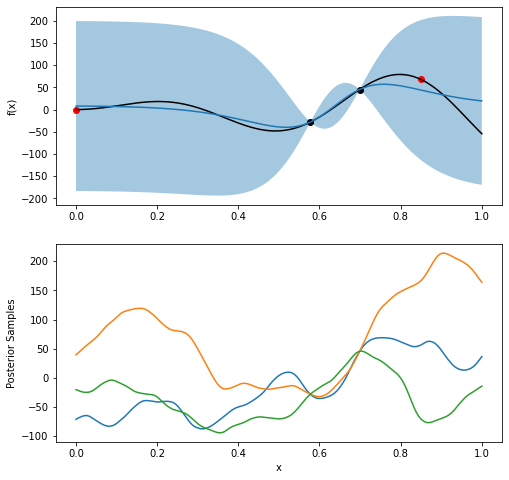



After 5 rounds of optimization:



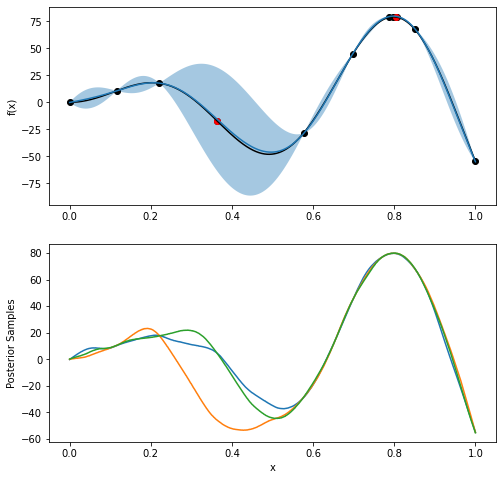

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import GammaPrior
from edbo.bro import BO

# Define a computational objective

def f(x):
    """Noise free objective."""
    
    return np.sin(10 * x[0]) * x[0] * 100
  
# BO uses a user defined domain

X = np.linspace(0,1,1000).reshape(1000, 1)
domain = pd.DataFrame(X, columns=['x'])                        # Search space

# Instantiate BO object

bo = BO(domain=domain,                                         # Search space
        target='f(x)',                                         # Name of target (not required but nice)
        acquisition_function='EI',                             # Acquisition function
        init_method='rand',                                    # Initialization method
        lengthscale_prior=[GammaPrior(1.2,1.1), 0.2],          # GP length scale prior and initial value
        noise_prior=None,                                      # No noise prior
        batch_size=2,                                          # Number of experiments to choose in parallel
        fast_comp=True,                                        # Use gpytorch fast computation features
        computational_objective=f)                             # The objective is defined as a function

# Select initial experiments

bo.init_sample(append=True, seed=4)

# Run a single iteration of BO

bo.run()

# Plot model and some posterior predictive samples (we need to unstandardize because BO standardizes internally)

def plot_results():
    """Plot summary of 1D BO simulations"""

    mean = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))                             # GP posterior mean
    std = np.sqrt(bo.model.variance(bo.obj.domain)) * bo.obj.scaler.std * 2                         # GP posterior standard deviation
    samples = bo.obj.scaler.unstandardize(bo.model.sample_posterior(bo.obj.domain, batch_size=3))   # GP samples
    next_points = bo.obj.get_results(bo.proposed_experiments)                                       # Next points proposed by BO
    results = bo.obj.results_input()                                                                # Results for known data

    plt.figure(1, figsize=(8,8))

    # Model mean and standard deviation
    plt.subplot(211)
    plt.plot(X.flatten(), [f(x) for x in X], color='black')
    plt.plot(X.flatten(), mean, label='GP')
    plt.fill_between(X.flatten(), mean-std, mean+std, alpha=0.4)

    # Known results and next selected point
    plt.scatter(results['x'], results['f(x)'], color='black', label='known')
    plt.scatter(next_points['x'], next_points['f(x)'], color='red', label='next_experiments')
    plt.ylabel('f(x)')

    # Samples
    plt.subplot(212)
    for sample in samples:
        plt.plot(X.flatten(), sample.numpy())
    plt.xlabel('x')
    plt.ylabel('Posterior Samples')
    plt.show()

print('\n\nAfter random initializaiton:\n')
plot_results()

# Run a simulation and plot results

print('\n\nAfter 5 rounds of optimization:\n')
bo.simulate(iterations=5, seed=4)
plot_results()


The BO class requires users to define their own encoded reaction spaces and choose model parameters. We imagined that a general, fully automated, approach to featurization would render BO more straightforward to apply by non-experts or on the fly. Thus, we also include a class, BO_express, which automates featurization, preprocessing, and selection of model parameters. Reaction components and encodings are passed to BO_express using dictionaries. Then BO_express attempts to encode each component based on the specified encoding type. When chemical names or nicknames are given, *edbo* will search the internet for the corresponding SMILES string. If there is an error in a SMILES string or the name of a molecule could not be found in the NIH database an edbo bot is spawned to help resolve the issue. Once instantiated, BO_express.help() will also spawn an edbo bot to help with tasks.

**BO_express Example code:**


edbo bot: For help try BO_express.help() or see the documentation page.

edbo bot: Building 1296 experiment reaction space...




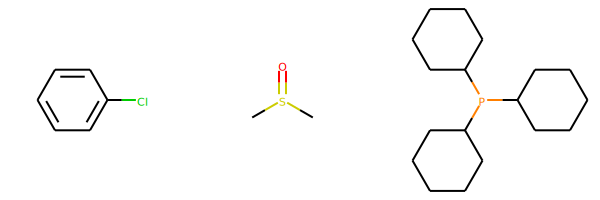

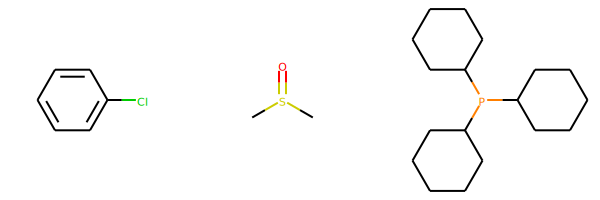

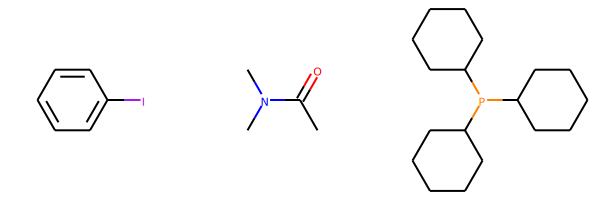

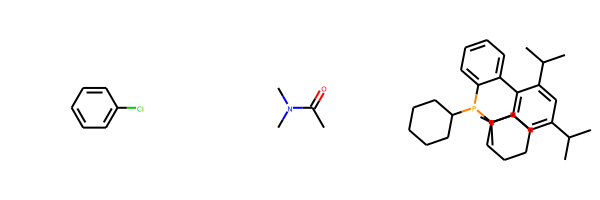

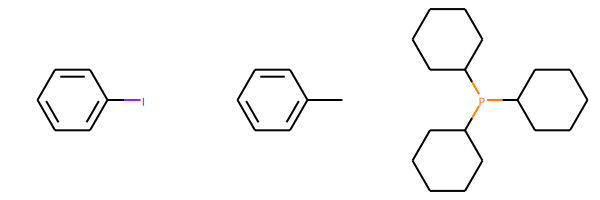

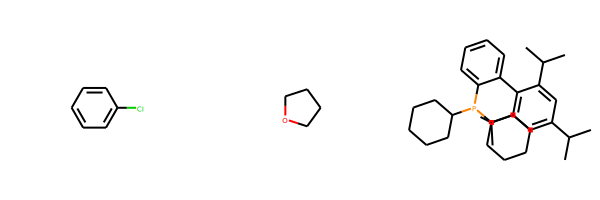

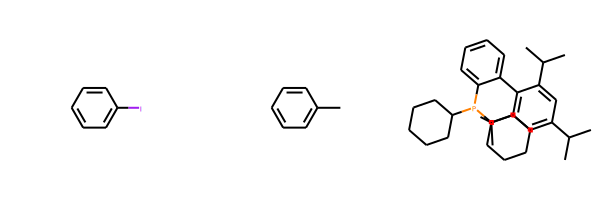

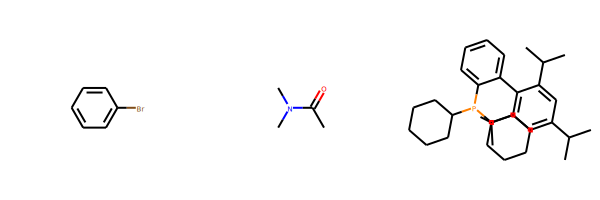

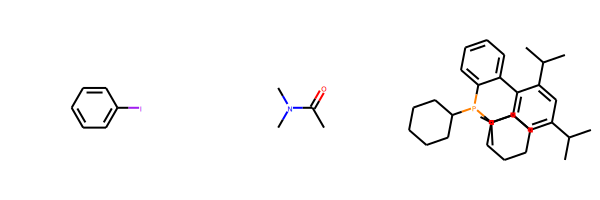

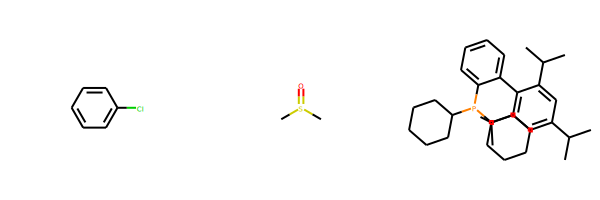

,aryl_halide_SMILES_index,base_index,solvent_SMILES_index,ligand_SMILES_index,concentration_index,temperature_index
176,Clc1ccccc1,MTBD,C[S](C)=O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,0.2,40
174,Clc1ccccc1,MTBD,C[S](C)=O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,0.2,20
850,Ic1ccccc1,potassium phosphate,CN(C)C(C)=O,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,0.2,30
318,Clc1ccccc1,potassium carbonate,CN(C)C(C)=O,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.2,20
577,Ic1ccccc1,MTBD,Cc1ccccc1,C1CCC(CC1)P(C2CCCCC2)C3CCCCC3,0.1,30
240,Clc1ccccc1,potassium carbonate,C1CCOC1,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.3,20
483,Ic1ccccc1,DBU,Cc1ccccc1,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.3,20
1073,Brc1ccccc1,MTBD,CN(C)C(C)=O,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.1,40
860,Ic1ccccc1,potassium phosphate,CN(C)C(C)=O,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.2,40
296,Clc1ccccc1,potassium carbonate,C[S](C)=O,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC...,0.3,40


In [2]:
from edbo.bro import BO_express
            
# (1) Define a dictionary of components
    
reaction_components={
    'aryl_halide':['chlorobenzene','iodobenzene','bromobenzene'],
    'base':['DBU', 'MTBD', 'potassium carbonate', 'potassium phosphate'],
    'solvent':['THF', 'Toluene', 'DMSO', 'DMAc'],
    'ligand': ['c1ccc(cc1)P(c2ccccc2)c3ccccc3', # PPh3
               'C1CCC(CC1)P(C2CCCCC2)C3CCCCC3', # PCy3
               'CC(C)c1cc(C(C)C)c(c(c1)C(C)C)c2ccccc2P(C3CCCCC3)C4CCCCC4' # X-Phos
               ],
    'concentration':[0.1, 0.2, 0.3],
    'temperature': [20, 30, 40]}
        
# (2) Define a dictionary of desired encodings
    
encoding={'aryl_halide':'resolve',
          'base':'ohe',
          'solvent':'resolve',
          'ligand':'smiles',
          'concentration':'numeric',
          'temperature':'numeric'}
        
# (3) Instatiate BO_express to automatically build the reaction space
    
bo = BO_express(reaction_components=reaction_components, 
                encoding=encoding,
                batch_size=10,
                acquisition_function='TS',
                target='yield')

# (4) Choose initial experiments via initialization method

bo.init_sample()
print('\n')
bo.get_experiments(structures=True)  # Use structures=True to 2D molecular structures of each experiment

Then to add experimental results you can use bo.add_results(). Once there is experimental data you can use bo.run() to run a single iteration of BO. Try help(edbo.bro.BO_express) to see a full lists of methods.

## Data

All data sets used to develop and test *edbo* can be accessed via the data_loader functions. Data loader functions return pandas.DataFrames of the encoded reactions. To run simulations, these data sets were then preprocessed using the edbo.utils.Data class. For DFT encodings all Gaussian output files, featurization source code, and descriptor computation/extraction scripts can be found on the *auto-qchem* GitHub page: https://github.com/b-shields/auto-QChem. After loading DFT data (*vide infra*), the quality of the DFT stationary points for each component can be assessed via the "<name>_convergence_criteria" columns. When "met" these columns indicate that the optimized geometries have no negative Hessian eigenvalues, maximum force < 0.000450, root-mean-square force < 0.000300, maximum displacement < 0.001800, and root-mean-square displacement < 0.001200 (or maximum force < 0.00001 and root-mean-square force < 0.00001).

Each descriptor set was treated by (1) removing or one-hot-encoding non-numeric features, (2) decorrelation by removing highly correlated features (Pearson correlation coefficient > 0.95) with any other selected descriptor, and (3) normalizing each feature on the unit hypercube. The standardization of responses (zero mean and unit variance) is handled internally by the software. Normalization of descriptors is important for GP model performance, for example because the priors were optimized for the [0,1] interval.

Note: "loading" can take a little while because the objectives are being reconstructed rather than actually loaded to save disk space.

**Example code:**

In [3]:
from data_loader import suzuki, aryl_amination, direct_arylation 

# Suzuki data

reaction1 = suzuki(electrophile='dft',                 # dft, mordred, or ohe
                   nucleophile='dft',                  # dft, mordred, or ohe
                   base='dft',                         # dft, mordred, or ohe
                   ligand='boltzmann-dft',             # random-dft, boltzmann-dft, mordred, or ohe
                   solvent='dft')                      # dft, mordred, or ohe

reaction1.head()

,entry,electrophile_file_name,electrophile_SMILES,electrophile_stoichiometry,electrophile_number_of_atoms,electrophile_charge,electrophile_multiplicity,electrophile_convergence_criteria,electrophile_dipole,electrophile_molar_mass,...,solvent_c_max-1_ES_root_NPA_core,solvent_c_max-1_ES_root_NPA_valence,solvent_c_max-1_ES_root_NPA_Rydberg,solvent_c_max-1_ES_root_NPA_total,solvent_atom1_%VBur,solvent_c_min_%VBur,solvent_c_min+1_%VBur,solvent_c_max_%VBur,solvent_c_max-1_%VBur,yield
0,1,Ar1Cl,ClC1=CC=C(N=CC=C2)C2=C1,C9H6ClN,17,0,1,met,1.939,163.6061,...,0.0,0.74073,0.00656,0.7473,0.284063,0.349091,0.284063,0.398701,0.304123,4.76
1,2,Ar1Cl,ClC1=CC=C(N=CC=C2)C2=C1,C9H6ClN,17,0,1,met,1.939,163.6061,...,0.0,0.74073,0.00656,0.7473,0.284063,0.349091,0.284063,0.398701,0.304123,4.12
2,3,Ar1Cl,ClC1=CC=C(N=CC=C2)C2=C1,C9H6ClN,17,0,1,met,1.939,163.6061,...,0.0,0.74073,0.00656,0.7473,0.284063,0.349091,0.284063,0.398701,0.304123,2.58
3,4,Ar1Cl,ClC1=CC=C(N=CC=C2)C2=C1,C9H6ClN,17,0,1,met,1.939,163.6061,...,0.0,0.74073,0.00656,0.7473,0.284063,0.349091,0.284063,0.398701,0.304123,4.44
4,5,Ar1Cl,ClC1=CC=C(N=CC=C2)C2=C1,C9H6ClN,17,0,1,met,1.939,163.6061,...,0.0,0.74073,0.00656,0.7473,0.284063,0.349091,0.284063,0.398701,0.304123,1.95


In [4]:
# Buchwald-Hartwig data

reaction2b = aryl_amination(aryl_halide='dft',         # dft, mordred, or ohe
                            additive='dft',            # dft, mordred, or ohe
                            base='dft',                # dft, mordred, or ohe
                            ligand='Pd(0)-dft',        # Pd(0)-dft, mordred, or ohe
                            subset=2)                  # (1) 2a, (2) 2b, (3) 2c, (4) 2d, (4) 2e

reaction2b.head()

,entry,aryl_halide_file_name,aryl_halide_SMILES,aryl_halide_stoichiometry,aryl_halide_number_of_atoms,aryl_halide_charge,aryl_halide_multiplicity,aryl_halide_convergence_criteria,aryl_halide_dipole,aryl_halide_molar_mass,...,Pd(0)-ligand_vib_42_standard_E-M_angle,Pd(0)-ligand_atom1_%VBur,Pd(0)-ligand_atom2_%VBur,Pd(0)-ligand_atom3_%VBur,Pd(0)-ligand_atom4_%VBur,Pd(0)-ligand_c_min_%VBur,Pd(0)-ligand_c_min+1_%VBur,Pd(0)-ligand_c_max_%VBur,Pd(0)-ligand_c_max-1_%VBur,yield
0,52,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,C7H7ClO,16,0,1,met,2.8944,142.5847,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,2.475058
1,68,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,C7H7ClO,16,0,1,met,2.8944,142.5847,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,0.456472
2,84,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,C7H7ClO,16,0,1,met,2.8944,142.5847,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,0.339837
3,100,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,C7H7ClO,16,0,1,met,2.8944,142.5847,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,0.000000
4,116,1-chloro-4-methoxybenzene,COc1ccc(Cl)cc1,C7H7ClO,16,0,1,met,2.8944,142.5847,...,84.6033,0.887309,0.843957,0.819377,0.826712,0.545074,0.550493,0.887309,0.534056,0.000000


In [5]:
# Direct arylation data

reaction3 = direct_arylation(base='dft',               # dft, mordred, or ohe
                             ligand='boltzmann-dft',   # random-dft, boltzmann-dft, mordred, or ohe
                             solvent='dft')            # dft, mordred, or ohe

reaction3.head()

,entry,base_file_name,base_SMILES,base_stoichiometry,base_number_of_atoms,base_charge,base_multiplicity,base_convergence_criteria,base_dipole,base_molar_mass,...,solvent_c_max-1_ES_root_NPA_valence,solvent_c_max-1_ES_root_NPA_Rydberg,solvent_c_max-1_ES_root_NPA_total,solvent_c_min_%VBur,solvent_c_min+1_%VBur,solvent_c_max_%VBur,solvent_c_max-1_%VBur,concentration,temperature,yield
0,0,KOAc,O=C([O-])C.[K+],C2H3KO2,8,0,1,met,7.1686,98.1428,...,0.75824,0.00092,0.75916,0.407832,0.653513,0.58603,0.395347,0.1,105,5.47
1,1,KOAc,O=C([O-])C.[K+],C2H3KO2,8,0,1,met,7.1686,98.1428,...,0.75824,0.00092,0.75916,0.407832,0.653513,0.58603,0.395347,0.1,105,0.00
2,2,KOAc,O=C([O-])C.[K+],C2H3KO2,8,0,1,met,7.1686,98.1428,...,0.75824,0.00092,0.75916,0.407832,0.653513,0.58603,0.395347,0.1,105,78.95
3,3,KOAc,O=C([O-])C.[K+],C2H3KO2,8,0,1,met,7.1686,98.1428,...,0.75824,0.00092,0.75916,0.407832,0.653513,0.58603,0.395347,0.1,105,7.26
4,4,KOAc,O=C([O-])C.[K+],C2H3KO2,8,0,1,met,7.1686,98.1428,...,0.75824,0.00092,0.75916,0.407832,0.653513,0.58603,0.395347,0.1,105,28.15


## Bayesian Reaction Optimization Experiments

In this section we define a simulation function for evaluating the performance of *edbo* in the optimization of reactions 1 and 2. These functions can be used to reproduce optimization results with the development objectives and to test other optimizer components.

**Load development data:**

In [6]:
from data_loader import suzuki, aryl_amination
from edbo.utils import Data

# Build search spaces for reactions 1 and 2 with DFT encoded components

reaction1 = Data(suzuki(electrophile='dft',
                        nucleophile='dft',
                        base='dft',
                        ligand='boltzmann-dft',
                        solvent='dft'))

reaction2a = Data(aryl_amination(aryl_halide='dft',
                                 additive='dft',
                                 base='dft',
                                 ligand='Pd(0)-dft',
                                 subset=1))
                  
reaction2b = Data(aryl_amination(aryl_halide='dft',
                                 additive='dft',
                                 base='dft',
                                 ligand='Pd(0)-dft',
                                 subset=2))

reaction2c = Data(aryl_amination(aryl_halide='dft',
                                 additive='dft',
                                 base='dft',
                                 ligand='Pd(0)-dft',
                                 subset=3))

reaction2d = Data(aryl_amination(aryl_halide='dft',
                                 additive='dft',
                                 base='dft',
                                 ligand='Pd(0)-dft',
                                 subset=4))

reaction2e = Data(aryl_amination(aryl_halide='dft',
                                 additive='dft',
                                 base='dft',
                                 ligand='Pd(0)-dft',
                                 subset=5))

# Preprocess data

for reaction in [reaction1, reaction2a, reaction2b, reaction2c, reaction2d, reaction2e]:

    # Remove nun-numeric and singular columns
    reaction.clean()

    # Drop columns with unimportant information
    reaction.drop(['entry', 'vibration', 'correlation', 'Rydberg', 'correction', 
                    'atom_number', 'E-M_angle', 'MEAN', 'STDEV'])
    
    # Standardize
    reaction.standardize(scaler='minmax')
    
    # Drop highly correlated features
    reaction.uncorrelated(threshold=0.95)

    # Encoded reaction
    reaction.data.head()

The classes edbo.bro.BO and edbo.bro.BO_express have built in functions for running simulations if the results in the domain are available as a tabulated list or there is an automated method for getting the results (see the use of the computational_objective option in the 1D example above).

**Example of a single optimization simulation using edbo:**

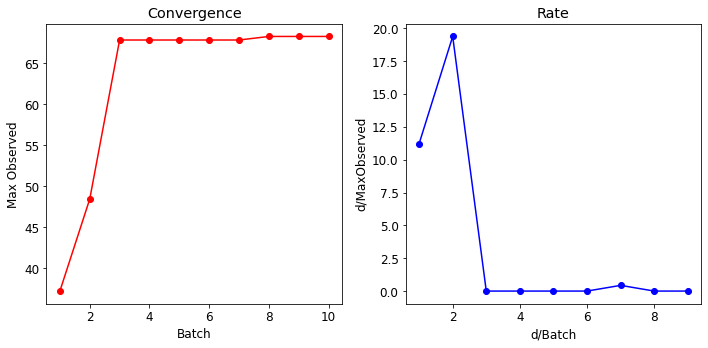

In [7]:
from edbo.bro import BO

# Instantiate edbo.BO
bo = BO(exindex=reaction2b.data,                       # Experiment index to look up results from
        domain=reaction2b.data.drop('yield', axis=1),  # Reaction space
        batch_size=3,                                  # Choose 3 experiments on each iteraiton 
        acquisition_function='EI',                     # Use expected improvement
        fast_comp=True)                                # Speed up the simulations using gpytorch's fast computation features

# Run simulation
bo.simulate(iterations=9, seed=0)

# Plot convergence
bo.plot_convergence()

Simulations used for the paper required averaging. Thus, we used *edbo* to build simulation functions which allowed us to run larger data experiments and get performance statistics. Let's define a simulation function which takes options for data, acquisition function, surrogate model, initialization method, number of experiments to choose in parallel, number of iterations to run the simulation, number of simulations to average, and analysis of the results. Then this function can be used to investigate the results presented in the paper.

**Define a simulation function:**

In [8]:
from edbo.models import GP_Model, RF_Model, Random
from edbo.plot_utils import average_convergence, plot_avg_convergence
import pandas as pd

# Function for simulating different BO parameters

def simulate(data,                 # Data container (vide supra)
             acq_func,             # Acquisition function: 'EI', 'PI', 'UCB', 'TS', ...
             model=GP_Model,       # Surrogate model: GP_Model or RF_Model
             init_method='rand',   # Initialization method: 'rand', 'pam', 'kmeans'
             batch_size=5,         # Parallel acquisition: int
             iterations=9,         # Number of iterations to run each simulation for
             average_of=10,        # Number of simulations to average
             export_path=None,     # Export the simulation results to a CSV file
             plot=False):          # Plot the average and standard deviation averaged convergence
    """
    Simulation function which averages BO runs with given optimization paramters.
    """
    
    # Average N optimizations with different random initializations
    results = []
    for i in range(average_of):
        
        # Use random function if the acquisition function is random selection
        if acq_func == 'rand':
            bo = BO(exindex=data.data,
                    domain=data.data.drop('yield', axis=1),
                    init_method=init_method,
                    model=Random,
                    batch_size=batch_size,
                    acquisition_function=acq_func)
        # Otherwise use specified model
        else:
            bo = BO(exindex=data.data,
                    domain=data.data.drop('yield', axis=1),
                    model=model,
                    init_method=init_method,
                    batch_size=batch_size,
                    acquisition_function=acq_func,
                    fast_comp=True)                            # Use gpytorch fast computation features
            
        # Simulate
        bo.init_seq.visualize = False
        bo.simulate(iterations=iterations, seed=i)
        
        # Append results to record
        results.append(bo.obj.results_input()['yield'].values)
        
    # Save the results to a CSV file
    results = pd.DataFrame(results)
    if export_path != None:
        results.to_csv(export_path)
        
    # Average performance
    index, mean, std = average_convergence(results, batch_size)
    
    # Plot
    if plot:
        plot_avg_convergence(results, batch_size)
        
    return results, mean, std


Now we can run an example simulation with averaging. In this case, let's use reaction 2b as the objective, a GP surrogate model, Probability of Improvement as an acquisition function, random selection for initialization, a batch size of 10, and average 10 different random initializations.

**Simulation Example:**

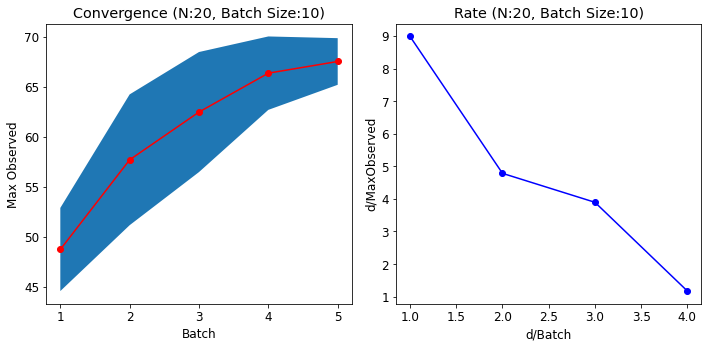

In [9]:
results, mean, std = simulate(reaction2b,           # Data from reaction 2b
                              'PI',                 # Probability of improvement 
                              model=GP_Model,       # Gaussian process model
                              init_method='rand',   # Random selection initialization
                              batch_size=10,        # Choose 10 experiments at a time
                              iterations=4,         # Run for 5 iterations including initialization
                              average_of=20,        # Run with 20 different random seeds
                              export_path=None,     # Don't save the results
                              plot=True)            # Plot the average results

In the paper we evaluated the performance of different acquisition functions in the optimization of reactions 1 and 2. These general results can be reproduced using the above simulation function. Let's reproduce the results for reaction 2b.

**Acquisition function performance simulations:**

Acquisition Function: EI


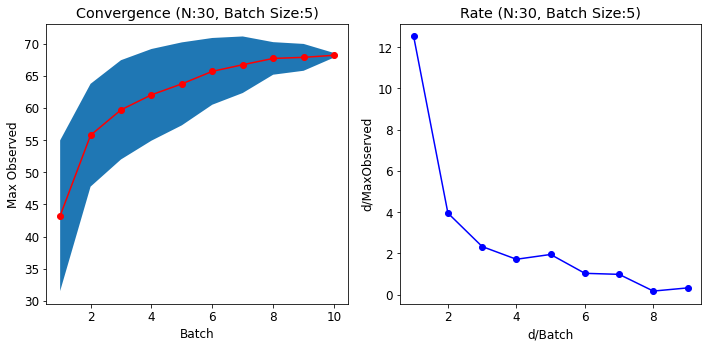

Acquisition Function: TS


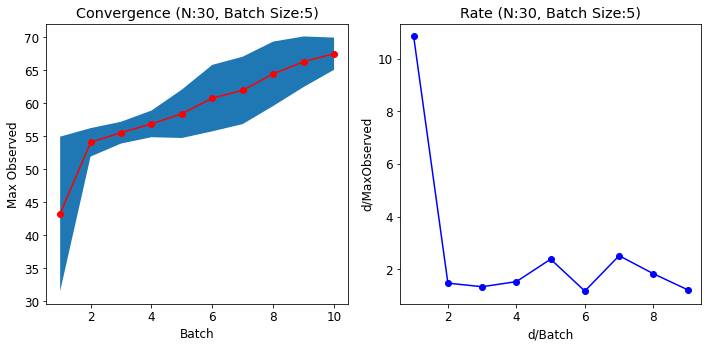

Acquisition Function: rand


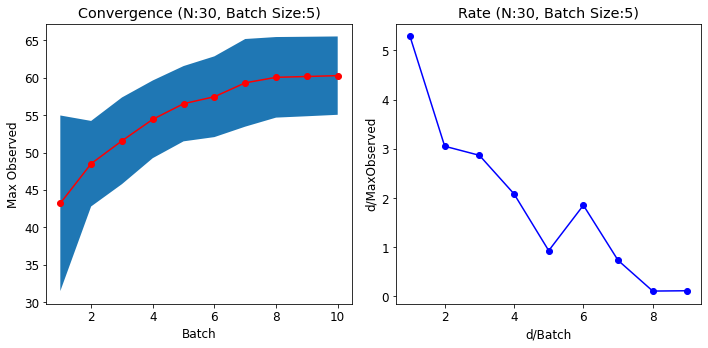

Acquisition Function: eps-greedy


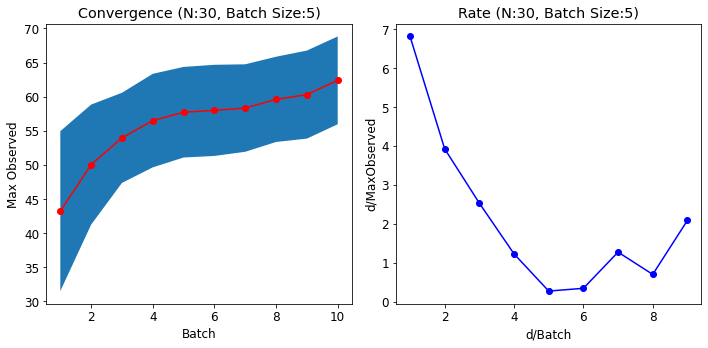

Acquisition Function: MeanMax


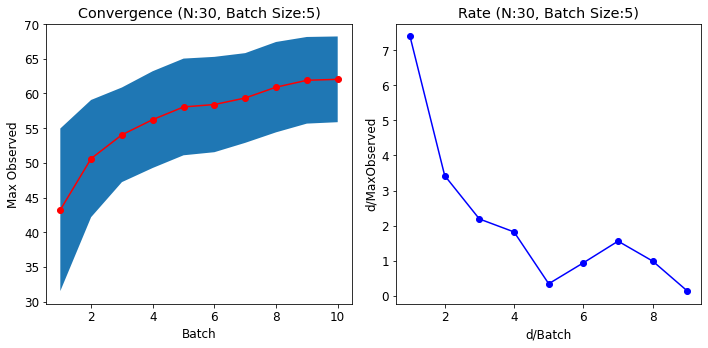

Acquisition Function: VarMax


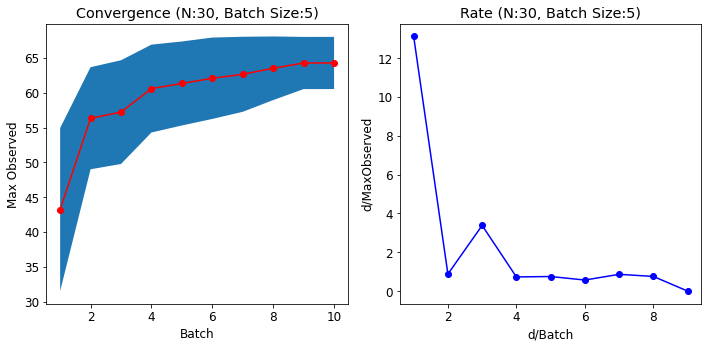

Average performance for all acquisition functions:


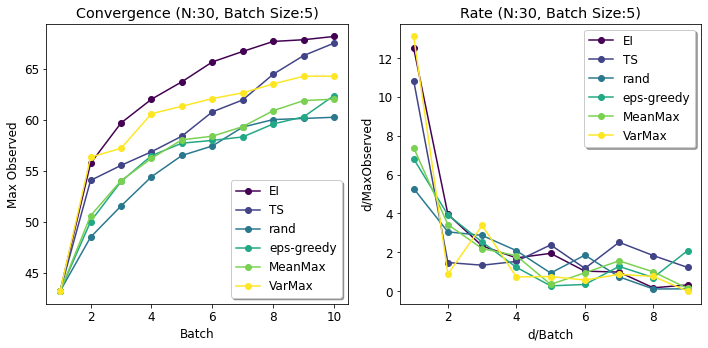

In [10]:
from edbo.plot_utils import compare_convergence

# Simulation

reaction = reaction2b
acq_funcs = ['EI', 'TS', 'rand', 'eps-greedy', 'MeanMax', 'VarMax']
acq_func_results = []

for acq_func in acq_funcs:
    # Run simulations
    print('Acquisition Function:', acq_func)
    results, mean, std = simulate(reaction,        # Data from reaction 
                              acq_func,            # Iterate over acq. funcs.
                              model=GP_Model,      # Gaussian process model
                              init_method='rand',  # Random initialization
                              batch_size=5,        # Choose 5 experiments at a time
                              iterations=9,        # Run for 9 iterations
                              average_of=30,       # Run with 30 different random seeds
                              export_path=None,    # Don't save the results
                              plot=True)           # Plot the average results
    # Save results
    acq_func_results.append(results)

# Compare average convergence for each acquisition function
print('Average performance for all acquisition functions:')
compare_convergence(acq_func_results, 5, acq_funcs)

Here we see that the software has given slightly different result from figure 3E. The primary difference is in the path taken by the Thompson sampling algorithm. This is because the method used to sample the posterior predictive distribution of the gaussian process model (edbo.models.GP_Model.sample_posterior) does not have a random seed. *Importantly, while the exact result simulation result is slightly different, the conclusions are the same: (1) EI did the best followed by TS and then pure exploration, (2) pure exploitation gave poor results (on average furnishing only marginally better decisions than random selection), and (3) $\epsilon$-greedy gave similar results to pure exploitation.*

## Exploration and Exploitation

As an illustration, in the paper we simulated the decisions made by acquisition functions which only exploit (mean maximization) and only explore (variance maximization). We visualized the decision in a 2D t-SNE embedding with domain points clustered using the k-means algorithm and tracked the fit to the overall space and yields of the selected experiments. We initialized the optimizers at the point closest to the center of one of the clusters. In this section we provide the code required to reproduce this example with any of the cluster centers. We will do this by clustering the data using the *k*-means algorithm, generating a 2D embedding, and then running BO with the explorer and exploiter while tracking the selected experiments, $R^2$ for the fit to the reaction space, and observed yield.

**Load development data:**

In [11]:
from data_loader import suzuki
from edbo.utils import Data

# Build search space for reaction 1 with DFT encoded components into a data container

reaction1 = Data(suzuki(electrophile='dft',
                        nucleophile='dft',
                        base='dft',
                        ligand='boltzmann-dft',
                        solvent='dft'))

# Preprocess data

# Remove nun-numeric and singular columns
reaction1.clean()

# Drop columns with unimportant information
reaction1.drop(['entry', 'vibration', 'correlation', 'Rydberg', 'correction', 
                'atom_number', 'E-M_angle', 'MEAN', 'STDEV'])
    
# Standardize
reaction1.standardize(scaler='minmax')
    
# Drop highly correlated features
reaction1.uncorrelated(threshold=0.95)

# Encoded reaction
reaction1.data.head()

,electrophile_number_of_atoms,electrophile_molar_mass,electrophile_hardness,electrophile_E_scf,electrophile_ES_root_dipole,electrophile_ES_root_molar_volume,electrophile_ES1_osc_strength,electrophile_ES5_transition,electrophile_ES5_osc_strength,electrophile_ES9_osc_strength,...,solvent_ES8_osc_strength,solvent_atom1_NPA_charge,solvent_atom1_ES_root_Mulliken_charge,solvent_atom1_ES_root_NPA_valence,solvent_c_min+1_ES_root_Mulliken_charge,solvent_c_max_NPA_charge,solvent_c_max_NPA_valence,solvent_c_min+1_%VBur,solvent_c_max-1_%VBur,yield
0,0.0,0.0,0.500766,0.8247,0.0736,0.31303,0.003781,0.0,1.0,0.912088,...,1.0,1.0,0.0,0.0,0.0,0.626452,0.886446,0.0,0.057541,4.76
1,0.0,0.0,0.500766,0.8247,0.0736,0.31303,0.003781,0.0,1.0,0.912088,...,1.0,1.0,0.0,0.0,0.0,0.626452,0.886446,0.0,0.057541,4.12
2,0.0,0.0,0.500766,0.8247,0.0736,0.31303,0.003781,0.0,1.0,0.912088,...,1.0,1.0,0.0,0.0,0.0,0.626452,0.886446,0.0,0.057541,2.58
3,0.0,0.0,0.500766,0.8247,0.0736,0.31303,0.003781,0.0,1.0,0.912088,...,1.0,1.0,0.0,0.0,0.0,0.626452,0.886446,0.0,0.057541,4.44
4,0.0,0.0,0.500766,0.8247,0.0736,0.31303,0.003781,0.0,1.0,0.912088,...,1.0,1.0,0.0,0.0,0.0,0.626452,0.886446,0.0,0.057541,1.95


To start we will cluster the data using the *k*-means algorithm and generate a *t*-SNE embedding for visualization. Here we will cluster the reaction space into five clusters, as in the paper. Note: we have found that sklearn's TSNE class can give slightly different embeddings even with a random seed.

**Cluster and embed:**

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

# Cluster

DATA = reaction1.data.drop('yield', axis=1)
clusterer = KMeans(n_clusters=5, random_state=0)
cluster_labels = clusterer.fit_predict(DATA)

# Get points closes to the cluster centers
closest = pd.DataFrame(columns=DATA.columns)
for i in range(5):
    cluster_i = DATA.iloc[np.where(clusterer.labels_ == i)]
    closest_i, _ = pairwise_distances_argmin_min(clusterer.cluster_centers_[[i]], cluster_i)
    closest = pd.concat([closest, cluster_i.iloc[closest_i]], sort=False)

# t-SNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_results = tsne.fit_transform(DATA)

You can choose which of the five clusters to start in by specifying the START value below. Let's plot the embedded clusters, points closest to their centers, and selected point. In the below plot the clusters are color coded, the points closest to the cluster centers are marked with *X*'s, and the selected starting point for Bayesian optimization is highlighted in blue.

**Plot clustering results:**

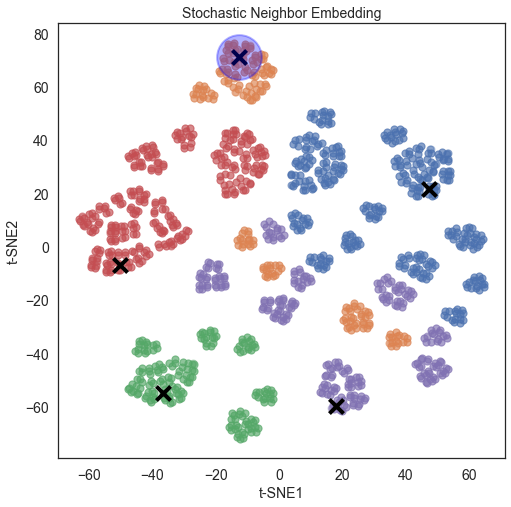

In [13]:
START = 1

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Plot

# Plot parameters
sns.set(rc={'figure.figsize':(8, 8)})
sns.set(rc={'font.size':14})
sns.set(style='darkgrid')
sns.set(style='white')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Plot each cluster
for i in range(5):
    cluster_i = np.argwhere(cluster_labels==i).flatten()
    plt.scatter(tsne_results[:, 0][cluster_i], 
                tsne_results[:, 1][cluster_i], 
                s=50, 
                lw=1,
                alpha=0.3)

# Plot centroids
plt.scatter(tsne_results[closest.index.values][:, 0],
            tsne_results[closest.index.values][:, 1],
            s=200,
            lw=4,
            marker="x",
            color='black')

# Plot starting point as center of cluster
plt.scatter([tsne_results[closest.index.values][START][0]],
            [tsne_results[closest.index.values][START][1]],
            s=2000,
            lw=2,
            marker="o",
            color='blue',
            alpha=0.3)
 
plt.title('Stochastic Neighbor Embedding', fontsize=14)
plt.xlabel("t-SNE1", fontsize=14)
plt.ylabel("t-SNE2", fontsize=14)

plt.show()

To run these simulations, we will need to write a new simulation function which keeps track of the path, $R^2$ for the fit to the whole space and yields for each experiment. In this case *edbo* does not have a built-in method compatible with this type of simulation. Therefore, we will write a custom function using the BO.run method which runs a single iteration of BO at a time. You can also use this function to investigate the decisions made by different acquisition functions using the acq_func argument.

**Define a simulation function and run the explorer and exploiter:**

In [14]:
from edbo.bro import BO
from edbo.math_utils import model_performance

# Simulation function

def simulation(acq_func, NSTEPS=50):
    """
    Run BO to track the optimization path of a given acquisition function.
    The arguement NSTEPS denotes the number of rounds of optimization to run.
    """
    
    start = closest.index.values[[START]]                                           # Set the starting point (vide supra)
    
    # Instantiate BO object
    bo = BO(exindex=reaction1.data,                                                 # Experiment index to look up results from
            domain=reaction1.data.drop('yield', axis=1),                            # Parameterized reaction space
            results=reaction1.data.iloc[start],                                     # Starting point
            init_method='external',                                                 # Since we are passing results use the 'external'
            batch_size=1,                                                           # Sequential optimization experiment
            acquisition_function=acq_func,                                          # Use GP mean maximization ro variance maximization
            fast_comp=True)                                                         # Use gpytorch's fast computation features

    # Iterate and track fit R^2
    r2 = []
    for i in range(NSTEPS):
        bo.run()                                                                    # Run a single iteration of BO
        pred = bo.obj.scaler.unstandardize(bo.model.predict(bo.obj.domain))         # Predict the response for the whole domain (needs to be unstandardized)
        obs = bo.obj.exindex['yield'].values                                        # Get observations
        RMSE, R2 = model_performance(pred, obs)                                     # Compute and save R^2
        r2.append(R2)                                                           
        bo.obj.get_results(bo.proposed_experiments, append=True)                    # Append results to the record
    
    # Get index and yield of results
    index = list(start) + list(bo.obj.results.index.values[1:])
    yield_ = list(bo.obj.results_input()['yield'].values)
    
    return index, yield_, r2

# Run simulations 

exploit, exploit_yield, exploit_r2 = simulation('MeanMax')  # Mean Maximizaiton
explore, explore_yield, explore_r2 = simulation('VarMax')   # Variance Maximizaiton


Now with the simulation results in hand we can plot the paths in the *t*-SNE embedding and $R^2$/yield against optimizer step. For the path we will use matplotlib's ConnectionPatch to draw arrows between the points selected by each algorithm. You can plot the first *N* choices of both algorithms by specifying keep = *N* below. For now, let's see what the first 10 choices look like when initialized from this particular cluster. Just as in the paper, we will give the explorer a dashed line arrow and the exploiter a solid lined arrow.

**Plot paths through reaction space:**

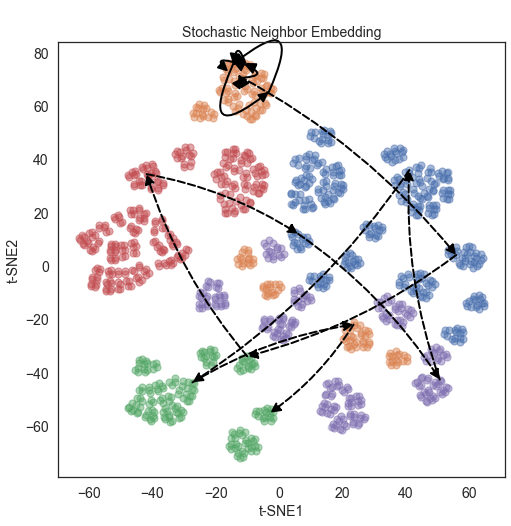

In [15]:
from matplotlib.patches import ConnectionPatch

# Plot results

keep = 10                                                    # Plot the first 10 choices

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Plot reaction space
for i in range(5): 
    cluster_i = np.argwhere(cluster_labels==i).flatten()
    ax1.scatter(tsne_results[:, 0][cluster_i], 
                tsne_results[:, 1][cluster_i], 
                s=50, 
                lw=1,
                alpha=0.2
               )

# Draw arrows for exploitation
for i in range(len(exploit[:keep]) - 1):
    arrow = np.array(exploit).flatten()
    xyA = tuple(tsne_results[arrow[i]])
    xyB = tuple(tsne_results[arrow[i + 1]])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA, xyB, coordsA, coordsB,
                      linestyle='-',
                      arrowstyle="-|>", 
                      shrinkA=0, shrinkB=0,
                      connectionstyle="arc3,rad=2",
                      mutation_scale=20, linewidth=2, color='black')
    ax1.add_artist(con)
    
# Draw arrows for exploration
for i in range(len(explore[:keep]) - 1):
    arrow = np.array(explore).flatten()
    xyA = tuple(tsne_results[arrow[i]])
    xyB = tuple(tsne_results[arrow[i + 1]])
    coordsA = "data"
    coordsB = "data"
    con = ConnectionPatch(xyA, xyB, coordsA, coordsB,
                      linestyle='--',
                      arrowstyle="-|>", 
                      shrinkA=0, shrinkB=0,
                      connectionstyle="arc3,rad=-0.1",
                      mutation_scale=20, linewidth=2, color='black')
    ax1.add_artist(con)

plt.title('Stochastic Neighbor Embedding', fontsize=14)
plt.xlabel("t-SNE1", fontsize=14)
plt.ylabel("t-SNE2", fontsize=14)    

plt.show()

**Plot model fit at each optimization step:**

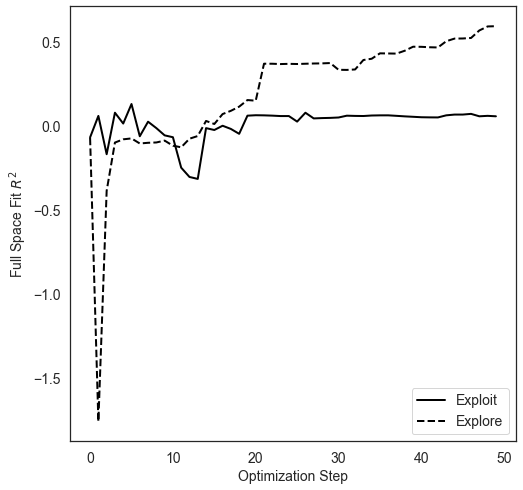

In [16]:
index = range(len(exploit_r2))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(index, exploit_r2, '-', color='black', lw=2, label='Exploit')
ax1.plot(index, explore_r2, '--', color='black', lw=2, label='Explore')
ax1.set_ylabel('Full Space Fit $R^{2}$', fontsize=14)
ax1.set_xlabel('Optimization Step', fontsize=14)
ax1.legend(loc='lower right', fontsize=14)

plt.show()

**Plot observed yield at each optimization step:**

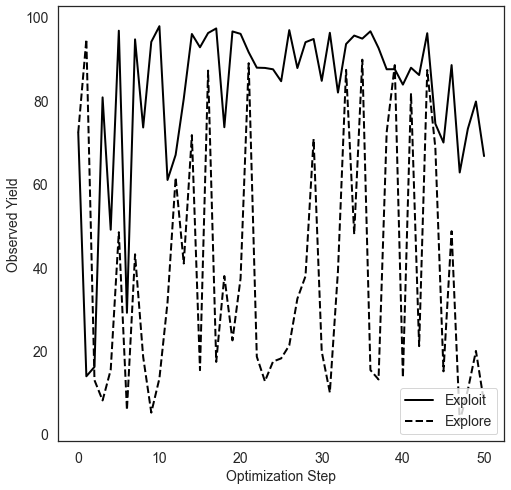

In [17]:
index = range(len(exploit_yield))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(index, exploit_yield, '-', color='black', lw=2, label='Exploit')
ax1.plot(index, explore_yield, '--', color='black', lw=2, label='Explore')
ax1.set_ylabel('Observed Yield', fontsize=14)
ax1.set_xlabel('Optimization Step', fontsize=14)
ax1.legend(loc='lower right', fontsize=14)

plt.show()

In this case we can see that the results presented in figure 3A and B can be reproduced when initialized from the different cluster centers. Namely (1) the exploiter remained in a single cluster while the explorer traversed the entire space, (2)  over the course of 50 experiments the $R^2$ scores of the explorer and exploiter diverge, with the explorer offering a significantly better fit to the reaction surface, and (3) most points selected by the explorer and exploiter gave low and high yields respectively.

## Test Set

The direct arylation test set collected for this study was not used at all in optimizer development. On the basis of data for rection 1 and 2a–e we established that BO performance was most promising using DFT reaction representations, a GP surrogate model, and expected improvement with batches selected via the Kriging believer algorithm as an acquisition function. Thus, we evaluated only this optimizer configuration on the test set. In this section we provide code to reproduce this experiment. In addition, we provide the results of our initial simulations as a CSV file for comparison. Finally, we provide data and code to compare with human performance.

Our experiments with reactions 1 and 2a–e suggested that optimization was feasible with only a small fraction of the search space (typically well below 100 experiments). Importantly, in a real application, it is not typically feasible to screen parameters like temperature using a single 96 well plates for HTE. Thus, to fully explore temperature for this search space using fully populated HTE plates would require a minimum of 288 reactions. Given the importance of parallel acquisition functions and the number of candidate experiments in the reaction space, we elected to carry out tests with a batch size of 5. This gives a reasonable model for optimization at the bench. In addition, we imagined selecting 5 parallel experiments would work well in human benchmarking experiments (vide infra).

**Load experimental data:**

In [18]:
from data_loader import direct_arylation
from edbo.utils import Data

# Build reaction space

reaction3 = Data(direct_arylation(base='dft',             
                                  ligand='boltzmann-dft',
                                  solvent='dft'))   

# Preprocess data

# Remove nun-numeric and singular columns
reaction3.clean()

# Drop columns with unimportant information
reaction3.drop(['entry', 'vibration', 'correlation', 'Rydberg', 'correction', 
                'atom_number', 'E-M_angle', 'MEAN', 'STDEV'])
    
# Standardize
reaction3.standardize(scaler='minmax')
    
# Drop highly correlated features
reaction3.uncorrelated(threshold=0.95)

# Encoded reaction
reaction3.data.head()

,base_number_of_atoms,base_dipole,base_homo_energy,base_ES_root_dipole,base_ES_root_molar_volume,base_ES1_osc_strength,base_ES3_osc_strength,base_ES4_osc_strength,base_ES6_osc_strength,base_ES9_osc_strength,...,solvent_c_min_atom=O,solvent_c_min_APT_charge,solvent_c_min_NPA_core,solvent_c_min_ES_root_Mulliken_charge,solvent_c_min+1_atom=N,solvent_c_min+1_NPA_charge,solvent_c_min+1_NPA_valence,concentration,temperature,yield
0,0.0,0.0,0.126129,0.373306,0.0,0.538462,1.0,0.0,0.163158,1.0,...,1.0,0.123729,1.0,1.0,1.0,1.0,0.416541,0.447917,0.5,5.47
1,0.0,0.0,0.126129,0.373306,0.0,0.538462,1.0,0.0,0.163158,1.0,...,1.0,0.123729,1.0,1.0,1.0,1.0,0.416541,0.447917,0.5,0.00
2,0.0,0.0,0.126129,0.373306,0.0,0.538462,1.0,0.0,0.163158,1.0,...,1.0,0.123729,1.0,1.0,1.0,1.0,0.416541,0.447917,0.5,78.95
3,0.0,0.0,0.126129,0.373306,0.0,0.538462,1.0,0.0,0.163158,1.0,...,1.0,0.123729,1.0,1.0,1.0,1.0,0.416541,0.447917,0.5,7.26
4,0.0,0.0,0.126129,0.373306,0.0,0.538462,1.0,0.0,0.163158,1.0,...,1.0,0.123729,1.0,1.0,1.0,1.0,0.416541,0.447917,0.5,28.15


Now we can define a simulation loop, using *edbo*'s built in simulation function, to evaluate the performance of BO on the direct arylation test set. In human benchmarking studies we had 50 participants play the game. Accordingly, we ran the simulation with 50 random initializations for statistical comparison.

**Testing BO performance:**

In [19]:
from edbo.bro import BO

# Simulation parameters

NSIM = 50       # Number of simulations to average
NBATCH = 19     # Number of batches to run BO for

# Simulation loop

results = []
for i in range(NSIM):
    
    # Instantiate BO object
    bo = BO(exindex=reaction3.data,
            domain=reaction3.data.drop('yield', axis=1),
            batch_size=5,
            init_method='rand',
            acquisition_function='EI',
            fast_comp=True)
    
    bo.simulate(iterations=NBATCH, seed=i)
    results.append(bo.obj.results_input()['yield'].values)
    
    # Uncomment this if you want to see the results as they come in
    # bo.plot_convergence()

In the paper we compare the optimizers decisions to those of the human participants. The convergence behavior of all human participants can be seen below and further analyzed using the available data. We found that 28/50 and 32/50 human participants achieved a yield that was within 1% and 5% of the maximum yield, respectively. As in the paper, we found in the reproduction run that 100% of randomly initialized BO runs achieved the optimal yield. This is in part due to some human participants not utilizing all 20 of their possible experiment batches (we deal with this issue below).

**Load human results and initial simulation results:**

In [20]:
import pandas as pd
import numpy as np

humans = pd.read_csv('arylation_game_summary.csv')
bo_paper = pd.read_csv('arylation_bo_results_GP-EI_bs=5.csv', index_col=0)
bo = pd.DataFrame(results)

In [21]:
humans.head()

,area,expertise,experience,yield_1,temp_1,conc_1,solvent_1,ligand_1,base_1,yield_2,...,conc_99,solvent_99,ligand_99,base_99,yield_100,temp_100,conc_100,solvent_100,ligand_100,base_100
0,Pharma,Process Chemist,1_5 years,5.47,105,0.100,DMAc,BrettPhos,KOAc,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pharma,Engineer,1_5 years,2.41,105,0.057,DMAc,BrettPhos,KOAc,0.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pharma,Process Chemist,1_5 years,5.47,105,0.100,DMAc,BrettPhos,KOAc,75.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pharma,Engineer,1_5 years,0.00,105,0.100,DMAc,PPhtBu2,KOAc,7.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pharma,Process Chemist,1_5 years,5.47,105,0.100,DMAc,BrettPhos,KOAc,65.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
bo_paper.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.83,0.00,13.85,19.84,4.09,43.22,17.63,28.40,92.19,52.47,...,89.71,2.52,67.85,52.56,50.75,89.17,3.51,81.63,83.62,50.69
1,31.85,0.00,2.95,7.25,98.49,95.48,26.39,28.90,84.03,52.23,...,84.62,91.39,27.88,50.75,6.48,5.65,84.48,83.85,90.39,14.06
2,0.00,53.81,42.04,23.51,0.00,0.00,21.50,69.03,49.57,71.81,...,6.18,53.49,41.10,69.20,50.69,54.26,73.33,76.63,40.04,44.22
3,32.36,7.84,0.00,7.74,49.19,50.55,4.98,36.29,58.13,2.49,...,89.17,0.00,6.23,70.80,0.00,26.12,48.86,40.06,44.48,50.69
4,7.69,0.00,0.00,8.23,0.00,16.76,45.01,74.30,39.57,10.49,...,62.07,0.00,53.49,50.70,92.03,88.89,2.72,65.32,5.90,14.06


In [23]:
bo.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.83,0.00,13.85,19.84,4.09,43.22,17.63,28.40,92.19,52.47,...,89.71,2.52,67.85,52.56,50.75,89.17,3.51,81.63,83.62,50.69
1,31.85,0.00,2.95,7.25,98.49,95.48,26.39,28.90,84.03,52.23,...,84.62,64.12,91.39,78.60,50.70,47.30,68.53,0.00,90.39,96.64
2,0.00,53.81,42.04,23.51,0.00,0.00,21.50,69.03,49.57,71.81,...,54.26,0.00,32.68,33.60,50.69,73.33,79.76,78.44,11.83,91.19
3,32.36,7.84,0.00,7.74,49.19,50.55,4.98,36.29,58.13,2.49,...,46.57,44.48,84.03,76.34,50.69,20.73,36.73,18.93,59.83,36.46
4,7.69,0.00,0.00,8.23,0.00,16.76,45.01,74.30,39.57,10.49,...,53.46,88.89,62.07,78.60,92.03,68.71,76.59,0.00,13.87,89.14


We will need some analysis functions to compute optimization paths from the data, average the results, and plot convergence. These are defined below.

**Define helpful analysis functions:**

In [24]:
# Plotting functions

yield_columns = ['yield_' + str(i) for i in range(1,101)]    # Columns in human participant data which correspond to yield

def max_observed(points, batch_size):
    """
    Compute max observed yield for each batch of experiments.
    """
    
    index = []
    max_obs = []
    for i in range(round(len(points)/batch_size)):
        current_max = points[:batch_size*(i+1)].max()
        max_obs.append(current_max)
        index.append(i+1)
        
    return index, max_obs

def average(df, batch_size):
    """
    Compute the point wise average of the max observed yield
    for each batch of experiments. Only average points that 
    are present (i.e. don't pad with zeros).
    """
    
    # Get max observed for each row
    data = []
    for i in range(len(df)):
        # Drop NAs
        entry = df.iloc[i].dropna().values
        # Get max observed values
        index, max_obs = max_observed(entry, batch_size)
        data.append(max_obs)
    
    # Average
    max_obs_table = pd.DataFrame(data)
    index = []
    avg = []
    stdev = []
    for i in range(len(max_obs_table.columns.values)):
        # Drop NAs
        entry = max_obs_table.iloc[:,i].dropna().values
        # Get average and stdev
        index.append(i + 1)
        avg.append(entry.mean())
        stdev.append(entry.std())
    
    return index, avg, stdev

def avg_subsets(column):
    """Get average convergence data for unique entries of a column."""

    # Break up by entry
    entries = list(humans[column].drop_duplicates().values)
    
    # Get subset averages
    avgs = []
    for entry in entries:
        subset = humans[humans[column] == entry][yield_columns]
        index, avg, stdev = average(subset, 5)
        avgs.append(avg)
        
    # Return lists
    return entries, avgs

def convergence(data_list, legend_list=None, xlabel='Experiment Batch', 
                ylabel='Max Observed Yield', export_path=None, alpha=1,
                colormap=plt.cm.viridis, figsize=(5,5), legendloc='lower right'):
    """Plot convergence of points in data list."""
        
    fig, ax = plt.subplots(1, figsize=figsize)
    
    # Legend
    legend = True
    if legend_list == None:
        legend = False
        legend_list = [i for i in range(len(data_list))]
    
    # Plot options
    if colormap != None:  
        ax.set_prop_cycle('color', [colormap(i) for i in np.linspace(0, 1, len(data_list))])
    ax.set(xlabel=xlabel, ylabel=ylabel)
    fig.tight_layout()
    
    # Plot
    for data, name in zip(data_list, legend_list):
        ax.plot(range(1,len(data)+1), data, lw=3, label=name, alpha=alpha)
        
    if legend:
        ax.legend(loc=legendloc)
        
    # Export & return
    if export_path != None:
        plt.savefig(export_path + '.svg', format='svg', dpi=1200, bbox_inches='tight')
        plt.show()
    else:
        return plt.show()

**Human performance:**

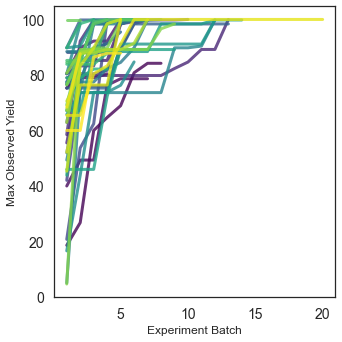

In [25]:
# Get paths and max observed
opt_paths_h = [humans[yield_columns].iloc[i].dropna().values for i in range(len(humans))]
max_obs_paths_h = []
for path in opt_paths_h:
    index, max_obs = max_observed(path, 5)
    max_obs_paths_h.append(max_obs)

# Plot max observed
convergence(max_obs_paths_h,
            alpha=0.8)

In [46]:
# Compute the number of humans within 1% and 5% of the max observed yield

print('Humans within 1% of max yield:', len(pd.DataFrame(opt_paths_h).max(axis=1)[pd.DataFrame(opt_paths_h).max(axis=1) > 99]))
print('Humans within 5% of max yield:', len(pd.DataFrame(opt_paths_h).max(axis=1)[pd.DataFrame(opt_paths_h).max(axis=1) > 95]))

Humans within 1% of max yield: 28
Humans within 5% of max yield: 32


**Reproduced Bayesian optimizer performance:**

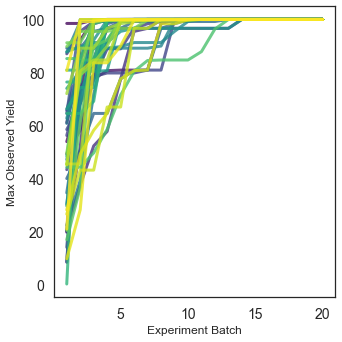

In [26]:
# Get paths and max observed
opt_paths_bo = bo.values
max_obs_paths_bo = []
for path in opt_paths_bo:
    index, max_obs = max_observed(path, 5)
    max_obs_paths_bo.append(max_obs)

# Plot max observed
convergence(max_obs_paths_bo,
            alpha=0.8)

In [44]:
# Compute the number of BO runs within 1% and 5% of the max observed yield

print('BO runs within 1% of max yield:', len(pd.DataFrame(opt_paths_bo).max(axis=1)[pd.DataFrame(opt_paths_bo).max(axis=1) > 99]))
print('BO runs within 5% of max yield:', len(pd.DataFrame(opt_paths_bo).max(axis=1)[pd.DataFrame(opt_paths_bo).max(axis=1) > 95]))

BO runs within 1% of max yield: 50
BO runs within 5% of max yield: 50


As in the paper experiments, we found that the optimizer typically converged to conditions which maximize yield of test reaction 3 withing 10 batches of 5 experiments (< 3% of experiments in the search space), irrespective of the 5 randomly selected reactions used for initialization. This trend is also reflected in the reproduction run.

The objective of this experiment was to statistically compare the optimization performance of BO and human experts. Each player had up to 20 batches of reactions for a total of 100 experiments to find the best experimental conditions. However, most participants played fewer than 20 rounds of experiments, for example because they believed they had achieved a globally optimal solution. Thus, in addition to comparing the raw optimization paths we sought to put hard bounds on average human performance in the data set. If we assume that players who stopped early would not have achieved any higher yielding conditions had they continued playing, we can impute a lower bound (worst case) on human performance. Conversely, if we assume optimistically that had players continued, they would have achieved 100% yield in their next batch of experiments, we can impute an upper bound (best case).

**Bounding human performance:**

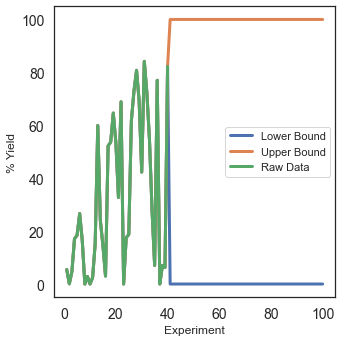

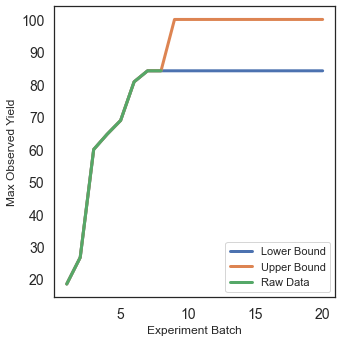

In [27]:
# Lower bound.

opt_paths_lower = humans[yield_columns].fillna(0.0).values     # Use fillna to replace with 0
max_obs_paths_lower = []
for path in opt_paths_lower:
    index, max_obs = max_observed(path, 5)
    max_obs_paths_lower.append(max_obs)

# Upper bound

opt_paths_upper = humans[yield_columns].fillna(100.0).values   # Use fillna to replace with 100
max_obs_paths_upper = []
for path in opt_paths_upper:
    index, max_obs = max_observed(path, 5)
    max_obs_paths_upper.append(max_obs)
    
# Plot path and max observed for an example
i = 0
convergence([opt_paths_lower[i], opt_paths_upper[i], opt_paths_h[i]],
            alpha=1,
            legend_list=['Lower Bound', 'Upper Bound', 'Raw Data'],
            colormap=None,
            legendloc='center right',
            xlabel='Experiment',
            ylabel='% Yield',
            export_path=None)

convergence([max_obs_paths_lower[i], max_obs_paths_upper[i], max_obs_paths_h[i]],
            alpha=1,
            legend_list=['Lower Bound', 'Upper Bound', 'Raw Data'],
            colormap=None,
            ylabel='Max Observed Yield',
            legendloc='lower right',
            export_path=None)

Now we can simply average the raw data, upper, and lower bound for comparison with BO.

**Bounding average human performance:**

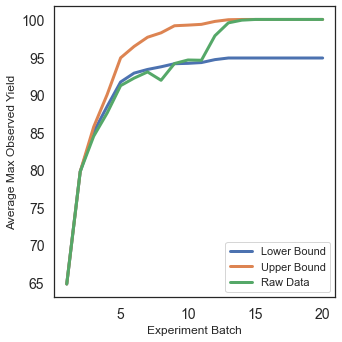

In [28]:
# Get averages
humans_i, humans_avg, humans_std = average(humans[yield_columns], 5)
humans_lower_i, humans_lower_avg, humans_lower_std = average(humans[yield_columns].fillna(0.0), 5)
humans_upper_i, humans_upper_avg, humans_upper_std = average(humans[yield_columns].fillna(100.0), 5)

convergence([humans_lower_avg, humans_upper_avg, humans_avg],
            alpha=1,
            legend_list=['Lower Bound', 'Upper Bound', 'Raw Data'],
            colormap=None,
            ylabel='Average Max Observed Yield',
            legendloc='lower right')

**Compare raw data and bounds to reproduced BO results:**

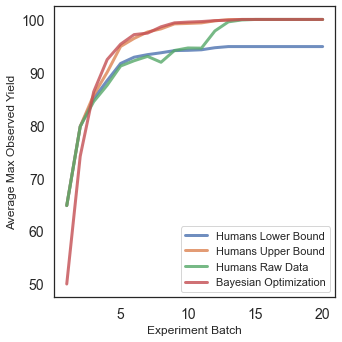

In [29]:
bo_i, bo_avg, bo_std = average(bo, 5)

convergence([humans_lower_avg, humans_upper_avg, humans_avg, bo_avg],
            alpha=0.8,
            legend_list=['Humans Lower Bound', 'Humans Upper Bound', 'Humans Raw Data', 'Bayesian Optimization'],
            colormap=None,
            ylabel='Average Max Observed Yield',
            legendloc='lower right')

Each of these bounds is unrealistic and the actual average performance of course would fall somewhere in between. However, notice that the raw averaged data (where we only average the available data for each batch of experiments and the number of points in batch i is not necessarily the same as batch i + 1) closely follows the lower bound up until batch 11. In addition, the upper bound closely follows the average path of the optimizer.

Comparing the bounds on average human convergence to average BO convergence suggests that BO offers improved performance in optimization. However, we wanted to assess their performance statistically. To do this, at each step in the optimization we conducted a hypothesis test under the null hypothesis that the central tendency of human and machine performance was identical. Here, we remove the assumption of equal variance between the two population samples and utilize an unpaired Welch’s t-test with Satterthwait degrees of freedom. To do this you may need to install statsmodels. When installing edbo it is not installed because it is not a dependency. The below code will try to install statsmodels via the IPython shell when defining the statistics functions.

**Hypothesis testing functions:**

In [30]:
try: 
    import statsmodels.stats.api as sms
except:
    !conda install -y statsmodels
    import statsmodels.stats.api as sms

def t_test(X1, X2, sample_vars='equal', print_out=True):
    """
    t-test for the null hypothesis of identical means. The unpaired 
    t-test should not be used if there is a significant difference 
    between the variances of the two samples. Here, if the variance
    of the samples is not assumed to be the same, then Welsh t-test 
    with Satterthwait degrees of freedom is used.
    """
    
    if sample_vars == 'equal':
        usevar = 'pooled'
    else:
        usevar = 'unequal'
        
    cm = sms.CompareMeans(sms.DescrStatsW(X1), sms.DescrStatsW(X2))
    ci = cm.tconfint_diff(usevar=usevar)
    t_value = cm.ttest_ind(usevar=usevar)
    
    if print_out == True:
        print('95% CI:', ci)
        print('DOF:', t_value[2])
        print('t-stat:', t_value[0])
        print('p-value:', t_value[1])
    else:
        return [t_value[2], t_value[0], t_value[1], ci[0], ci[1]]

# t-test for optimization paths
  
def path_stats(pop1_paths, pop2_paths, steps=range(21)):
    """
    Conduct a Welsh's t-test with the null hypothesis of identical
    means at each step of optimization.
    """

    summary = []
    for i in steps:
        
        # Data for optimization step i
        pop1 = pop1_paths.iloc[:,i].dropna().values
        pop2 = pop2_paths.iloc[:,i].dropna().values
        
        # Hypothesis test
        test = t_test(pop1, 
                      pop2, 
                      sample_vars='unequal', 
                      print_out=False)
        
        summary.append([i] + test)
    
    columns = ['Batch', 'DOF', 't-value', 'p-value', '95% CI (l)', '95% CI (u)']
    summary = pd.DataFrame(summary, columns=columns)
    
    return summary

For example, consider the distribution of max observed yields for batch 1 of human and BO decisions. Using the above functions, a Welch’s t-test with $H0: μ_{Human} = μ_{BO}$ gives t = 2.99 and p = 0.0035. Thus, we reject the null hypothesis and conclude the initial choice distributions do not have an identical average. Further, we infer from their averages that humans tended to make better initial decisions than random selection. 

**Example t-test for first step:**

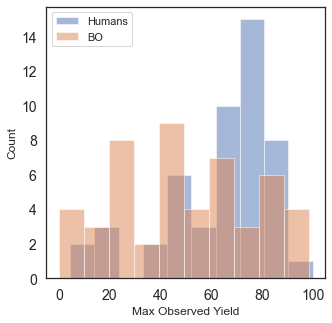


Students t-test:

95% CI: (5.001901725920172, 24.65769827407984)
DOF: 98.0
t-stat: 2.994460731576139
p-value: 0.0034806522703018914

Welchs t-test:

95% CI: (4.998111592946573, 24.66148840705344)
DOF: 95.06771475013356
t-stat: 2.994460731576139
p-value: 0.003504639041543614


In [31]:
# Data
step = 0
human_step = pd.DataFrame(max_obs_paths_h).iloc[:,step].dropna().values
bo_step = pd.DataFrame(max_obs_paths_bo).iloc[:,step].dropna().values

# Disributions
fig, ax = plt.subplots(1, figsize=(5,5))
ax.hist(human_step, alpha=0.5, label='Humans')
ax.hist(bo_step, alpha=0.5, label='BO')
ax.legend(loc='upper left')
ax.set_xlabel('Max Observed Yield')
ax.set_ylabel('Count')
plt.show()

# t-tests
print('\nStudents t-test:\n')
t_test(human_step, bo_step, sample_vars='equal')
print('\nWelchs t-test:\n')
t_test(human_step, bo_step, sample_vars='unequal')

Now, by carrying out this analysis at each step in the optimization for the null hypotheses $μ_{Human} = μ_{BO}$, $μ_{Lower} = μ_{BO}$, and $μ_{Upper} = μ_{BO}$ we can statistically compare convergence behavior of each case.

**Compute statistics for the entire path:**

In [32]:
humans_vs_bo = path_stats(pd.DataFrame(max_obs_paths_h), pd.DataFrame(max_obs_paths_bo), steps=range(14))
upper_vs_bo = path_stats(pd.DataFrame(max_obs_paths_upper), pd.DataFrame(max_obs_paths_bo), steps=range(20))
lower_vs_bo = path_stats(pd.DataFrame(max_obs_paths_lower), pd.DataFrame(max_obs_paths_bo), steps=range(20))

print('\n', humans_vs_bo.head())
print('\n', upper_vs_bo.head())
print('\n', lower_vs_bo.head())



    Batch        DOF   t-value   p-value  95% CI (l)  95% CI (u)
0      0  95.067715  2.994461  0.003505    4.998112   24.661488
1      1  91.724019  1.630232  0.106482   -1.228430   12.481230
2      2  93.513534 -0.683287  0.496115   -7.288975    3.556818
3      3  88.956214 -2.154587  0.033896   -9.338251   -0.377886
4      4  56.588120 -2.004383  0.049823   -8.263069   -0.003304

    Batch        DOF   t-value   p-value  95% CI (l)  95% CI (u)
0      0  95.067715  2.994461  0.003505    4.998112   24.661488
1      1  91.724019  1.630232  0.106482   -1.228430   12.481230
2      2  96.192879 -0.228999  0.819356   -5.986336    4.747936
3      3  96.153957 -1.093374  0.276961   -6.757033    1.957033
4      4  97.626405 -0.260170  0.795281   -3.744529    2.876529

    Batch        DOF   t-value   p-value  95% CI (l)  95% CI (u)
0      0  95.067715  2.994461  0.003505    4.998112   24.661488
1      1  91.724019  1.630232  0.106482   -1.228430   12.481230
2      2  95.346967 -0.484930  0.6

C:\Users\Ben\Anaconda3\envs\edbo\lib\site-packages\statsmodels\stats\weightstats.py:850: RuntimeWarning: invalid value encountered in double_scalars
  z1 = (sem1 / semsum)**2 / (d1.nobs - 1)
C:\Users\Ben\Anaconda3\envs\edbo\lib\site-packages\statsmodels\stats\weightstats.py:851: RuntimeWarning: invalid value encountered in double_scalars
  z2 = (sem2 / semsum)**2 / (d2.nobs - 1)
C:\Users\Ben\Anaconda3\envs\edbo\lib\site-packages\scipy\stats\_continuous_distns.py:5917: RuntimeWarning: invalid value encountered in greater
  return df > 0
C:\Users\Ben\Anaconda3\envs\edbo\lib\site-packages\statsmodels\stats\weightstats.py:617: RuntimeWarning: invalid value encountered in double_scalars
  tstat = (value1 - value2 - diff) / std_diff
C:\Users\Ben\Anaconda3\envs\edbo\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Now we can plot the p-values for each case. A p-value < 0.05 indicates that we can reject the null hypothesis. That is, the performance of humans and machines are statistically different. For the raw data and lower bound, we found that on average after the 5th batch of experiments the optimizers performance is better than that of the humans. In contrast, for the upper bound we found that there is not a statistically significant difference between the two average curves. Thus, we conclude that in the optimization of reaction 3, Bayesian reaction optimization on average outperforms human experts, tracing the unrealistic absolute upper bound of the games recorded data.

**Plot a summary figure:**

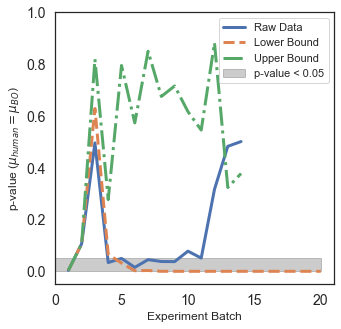

In [33]:
fig, ax3 = plt.subplots(1, figsize=(5,5))

# p < 0.05
ax3.fill_between([0,20], [0.05, 0.05], color='black', alpha=0.2, label='p-value < 0.05')

# Paths
ax3.plot(range(1,15), humans_vs_bo['p-value'], linewidth=3, label='Raw Data')
ax3.plot(range(1,21), lower_vs_bo['p-value'], '--', linewidth=3, label='Lower Bound')
ax3.plot(range(1,21), upper_vs_bo['p-value'], '-.', linewidth=3, label='Upper Bound')

# Parameters
ax3.set_ylim(-0.05, 1)
ax3.set_ylabel('p-value ($\mu_{human}=\mu_{BO}$)')
ax3.set_xlabel('Experiment Batch')
ax3.set_xlim(0,21)
ax3.legend(loc='upper right')

plt.show()
